# Using HMM for Latent Variable Inference on P. falciparum Strain 3D7 Chromosome 1

## Load libraries

In [48]:
from Bio import SeqIO
import numpy as np
import random
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

random.seed(88)
np.random.seed(88)

## Load genome and annotation data locally

In [6]:
# load local genome file
def load_local_genome(filename):
    try:
        record = SeqIO.read(filename, "fasta")
        dna_sequence = str(record.seq)
        
        print(f"Loaded local genome file")
        print(f"Description: {record.description}")
        print(f"Length: {len(dna_sequence):,} bp")
        
        return dna_sequence
    except Exception as e:
        print(f"Failed to load local file: {e}")
        raise
dna_sequence = load_local_genome("data/sequence.fasta")


Loaded local genome file
Description: NC_004325.2 Plasmodium falciparum 3D7 genome assembly, chromosome: 1
Length: 640,851 bp


In [11]:
# load and parse annotation file
def parse_plasmodium_ncbi_gff(gff_filename: str, genome_length: int) -> List[int]:
    """Parse P. falciparum GFF3 from NCBI RefSeq."""
    
    annotations = [0] * genome_length
    
    with open(gff_filename, 'r') as f:
        lines = f.readlines()
    
    # find chromosome/sequence names in the file
    sequence_names = set()
    feature_types = set()
    
    for line in lines:
        if not line.startswith('#') and line.strip():
            fields = line.strip().split('\t')
            if len(fields) >= 9:
                sequence_names.add(fields[0])
                feature_types.add(fields[2])
    
    print(f"NCBI sequences found: {sorted(list(sequence_names))[:3]}...")
    print(f"Feature types found: {sorted(list(feature_types))}")
    
    # NCBI RefSeq specific naming patterns
    main_sequence = None
    for seq in sequence_names:
        # look for RefSeq chromosome identifiers
        if 'NC_' in seq or 'NW_' in seq:
            main_sequence = seq
            break
        # look for Plasmodium-specific patterns
        elif 'Pf' in seq or 'MAL' in seq:
            main_sequence = seq
            break
    
    if not main_sequence:
        # use the first/longest sequence name
        main_sequence = max(sequence_names, key=len) if sequence_names else None
    
    print(f"Using sequence: {main_sequence}")
    
    if not main_sequence:
        print("ERROR: No valid sequence identifier found in GFF")
        return annotations
    
    processed_genes = 0
    processed_cds = 0
    
    for line in lines:
        if line.startswith('#') or not line.strip():
            continue
            
        fields = line.strip().split('\t')
        if len(fields) < 9:
            continue
            
        seqname = fields[0]
        feature_type = fields[2]
        
        # only process features from target sequence
        if seqname == main_sequence:
            
            # process gene and CDS features
            if feature_type in ['gene', 'CDS']:
                try:
                    start = int(fields[3]) - 1  # convert to 0-based
                    end = int(fields[4])
                    
                    # ensure coordinates are valid
                    start = max(0, start)
                    end = min(end, genome_length)
                    
                    if start < end:
                        # mark as exonic
                        for pos in range(start, end):
                            annotations[pos] = 1

                        if feature_type == 'gene':
                            processed_genes += 1
                        else:
                            processed_cds += 1
                        
                except ValueError:
                    continue
    
    exonic_count = sum(annotations)
    intergenic_count = genome_length - exonic_count
    density = exonic_count / genome_length * 100
    
    # print parsing results
    print(f"\nP. falciparum parsing results:")
    print(f"  Genome length: {genome_length:,} bp")
    print(f"  Processed genes: {processed_genes:,}")
    print(f"  Processed CDS: {processed_cds:,}")
    print(f"  Exonic positions: {exonic_count:,} bp")
    print(f"  Intergenic positions: {intergenic_count:,} bp") 
    print(f"  Gene density: {density:.1f}%")
    
    return annotations

# parse and load annotations
annotations = parse_plasmodium_ncbi_gff('data/sequence.gff3', len(dna_sequence))

NCBI sequences found: ['NC_004325.2']...
Feature types found: ['CDS', 'exon', 'gene', 'mRNA', 'ncRNA', 'pseudogene', 'rRNA', 'region', 'sequence_feature', 'snoRNA']
Using sequence: NC_004325.2

P. falciparum parsing results:
  Genome length: 640,851 bp
  Processed genes: 144
  Processed CDS: 349
  Exonic positions: 315,819 bp
  Intergenic positions: 325,032 bp
  Gene density: 49.3%


## Create train/test split

In [20]:
def create_split(dna_sequence: str, annotations: List[int]) -> Tuple:
    genome_length = len(dna_sequence)
    
    # window size based on genome length
    if genome_length > 5000000:  # lg chromosome 
        window_size = 5000
        step_size = 2500
    elif genome_length > 1000000:  # m chromosome 
        window_size = 3000
        step_size = 1500
    else:  # sm chromosome (
        window_size = 2000
        step_size = 1000
    
    print(f"Using window size: {window_size:,} bp, step: {step_size:,} bp")
    
    sequences = []
    sequence_annotations = []
    
    # sample overlapping windows
    for i in range(0, genome_length - window_size, step_size):
        seq = dna_sequence[i:i + window_size]
        ann = annotations[i:i + window_size]
        
        sequences.append(seq)
        sequence_annotations.append(ann)
    
    print(f"Created {len(sequences):,} total windows")
    
    # 80/20 split
    random.shuffle(list(zip(sequences, sequence_annotations)))
    n_train = int(len(sequences) * 0.8)

    train_sequences = sequences[:n_train]
    train_annotations = sequence_annotations[:n_train]
    test_sequences = sequences[n_train:]
    test_annotations = sequence_annotations[n_train:]

    return train_sequences, train_annotations, test_sequences, test_annotations
    
# create splits
train_seq, train_ann, test_seq, test_ann = create_split(dna_sequence, annotations)    

Using window size: 2,000 bp, step: 1,000 bp
Created 639 total windows


## Descriptive Analysis

### Density Statistics

In [21]:
# calculate and density statistics
def calc_density(annotations_list):
    total_pos = sum(len(ann) for ann in annotations_list)
    total_exonic = sum(sum(ann) for ann in annotations_list)
    return total_exonic / total_pos * 100 if total_pos > 0 else 0

train_density = calc_density(train_ann)
test_density = calc_density(test_ann)

print(f"Training: {len(train_seq):,} windows, {train_density:.1f}% gene density")
print(f"Test: {len(test_seq):,} windows, {test_density:.1f}% gene density")

Training: 511 windows, 53.9% gene density
Test: 128 windows, 31.7% gene density


### Segment Lengths

In [23]:
# calculate average gene and intergenic lengths
def calculate_segment_lengths(annotations_list, set_name):
    all_gene_lengths = []
    all_intergenic_lengths = []
    
    for ann in annotations_list:
        if len(ann) == 0:
            continue
            
        # find runs of consecutive states
        current_state = ann[0]
        current_length = 1
        
        for i in range(1, len(ann)):
            if ann[i] == current_state:
                current_length += 1
            else:
                # state change - record the segment
                if current_state == 1:  # gene
                    all_gene_lengths.append(current_length)
                else:  # intergenic
                    all_intergenic_lengths.append(current_length)
                
                # start new segment
                current_state = ann[i]
                current_length = 1
        
        # last segment
        if current_state == 1:
            all_gene_lengths.append(current_length)
        else:
            all_intergenic_lengths.append(current_length)
    
    avg_gene = sum(all_gene_lengths) / len(all_gene_lengths) if all_gene_lengths else 0
    avg_intergenic = sum(all_intergenic_lengths) / len(all_intergenic_lengths) if all_intergenic_lengths else 0
    
    print(f"{set_name} segment lengths:")
    print(f"  Average gene length: {avg_gene:.0f} bp (from {len(all_gene_lengths)} segments)")
    print(f"  Average intergenic length: {avg_intergenic:.0f} bp (from {len(all_intergenic_lengths)} segments)")
    print("\n")
    
    return avg_gene, avg_intergenic, len(all_gene_lengths), len(all_intergenic_lengths)

# calculate average gene and intergenic lengths for both sets
train_gene_len, train_inter_len, train_gene_count, train_inter_count = calculate_segment_lengths(train_ann, "Training")
test_gene_len, test_inter_len, test_gene_count, test_inter_count = calculate_segment_lengths(test_ann, "Test")

Training segment lengths:
  Average gene length: 1046 bp (from 526 segments)
  Average intergenic length: 997 bp (from 473 segments)


Test segment lengths:
  Average gene length: 1083 bp (from 75 segments)
  Average intergenic length: 1398 bp (from 125 segments)




### Nucleotide Composition Analysis

In [31]:
# calculate nucleotide content
def calculate_content(sequences, annotations_list, set_name):
    # count nucleotides by region type
    exonic_counts = {'A': 0, 'T': 0, 'G': 0, 'C': 0}
    intergenic_counts = {'A': 0, 'T': 0, 'G': 0, 'C': 0}
    
    for seq, ann in zip(sequences, annotations_list):
        if len(seq) != len(ann):
            min_len = min(len(seq), len(ann))
            seq = seq[:min_len]
            ann = ann[:min_len]
        
        for nucleotide, state in zip(seq, ann):
            if nucleotide in ['A', 'T', 'G', 'C']:
                if state == 1:  # exonic
                    exonic_counts[nucleotide] += 1
                else:  # intergenic
                    intergenic_counts[nucleotide] += 1
    
    # AT/GC content percentages
    exonic_total = sum(exonic_counts.values())
    intergenic_total = sum(intergenic_counts.values())
    
    if exonic_total > 0:
        exonic_at = (exonic_counts['A'] + exonic_counts['T']) / exonic_total * 100
        exonic_gc = (exonic_counts['G'] + exonic_counts['C']) / exonic_total * 100
    else:
        exonic_at = exonic_gc = 0
        
    if intergenic_total > 0:
        intergenic_at = (intergenic_counts['A'] + intergenic_counts['T']) / intergenic_total * 100
        intergenic_gc = (intergenic_counts['G'] + intergenic_counts['C']) / intergenic_total * 100
    else:
        intergenic_at = intergenic_gc = 0
    
    return {
        'exonic_at': exonic_at,
        'exonic_gc': exonic_gc,
        'intergenic_at': intergenic_at,
        'intergenic_gc': intergenic_gc,
        'exonic_counts': exonic_counts,
        'intergenic_counts': intergenic_counts,
        'exonic_total': exonic_total,
        'intergenic_total': intergenic_total
    }

# calculate AT content for both sets
train_composition = calculate_content(train_seq, train_ann, "Training")
test_composition = calculate_content(test_seq, test_ann, "Test")

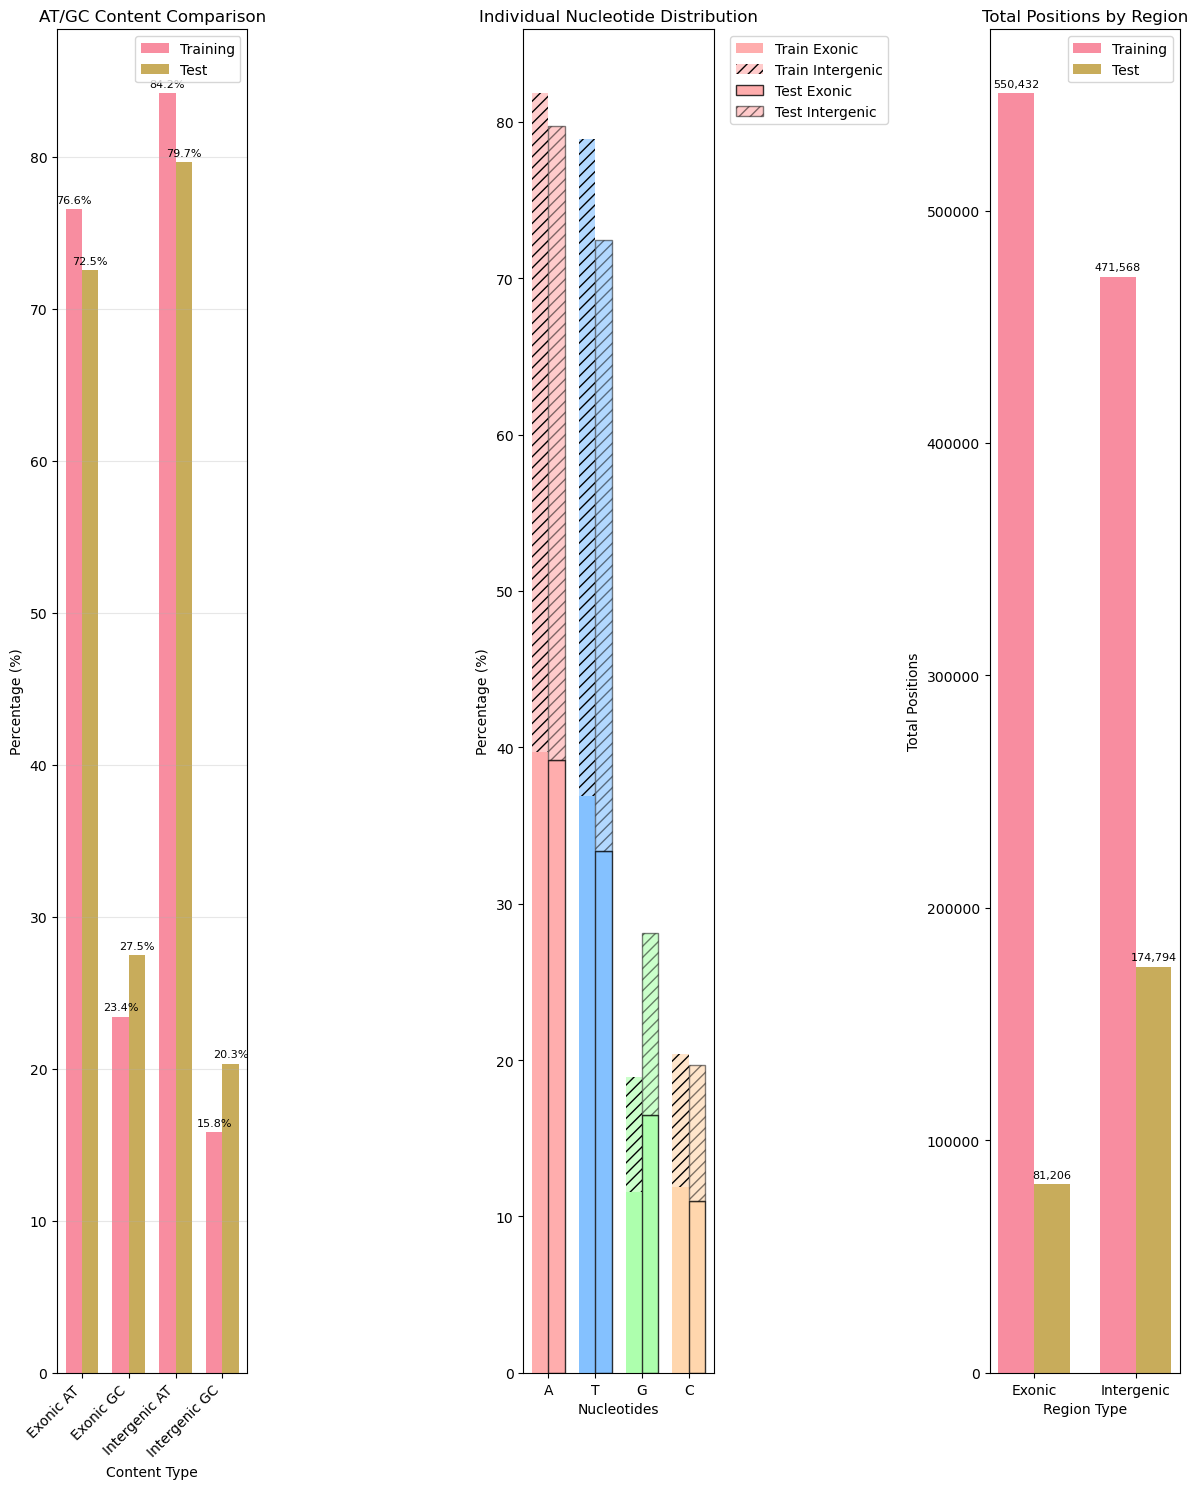

In [ ]:
# visualizations for nucleotide composition analysis

def create_nucleotide_visualizations(train_composition, test_composition):
    # plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # create figure with multiple subplots
    fig = plt.figure(figsize=(12, 15))
    
    ## AT/GC content comparison bar chart ##
    ax1 = plt.subplot(1, 3, 1)
    categories = ['Exonic AT', 'Exonic GC', 'Intergenic AT', 'Intergenic GC']
    train_values = [train_composition['exonic_at'], train_composition['exonic_gc'], 
                   train_composition['intergenic_at'], train_composition['intergenic_gc']]
    test_values = [test_composition['exonic_at'], test_composition['exonic_gc'],
                  test_composition['intergenic_at'], test_composition['intergenic_gc']]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, train_values, width, label='Training', alpha=0.8)
    bars2 = ax1.bar(x + width/2, test_values, width, label='Test', alpha=0.8)
    
    ax1.set_xlabel('Content Type')
    ax1.set_ylabel('Percentage (%)')
    ax1.set_title('AT/GC Content Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
    
    ## stacked bar individual nucleotide breakdown ##
    ax2 = plt.subplot(1, 3, 2)
    nucleotides = ['A', 'T', 'G', 'C']
    train_exonic = [train_composition['exonic_counts'][n]/train_composition['exonic_total']*100 
                   for n in nucleotides] if train_composition['exonic_total'] > 0 else [0,0,0,0]
    train_intergenic = [train_composition['intergenic_counts'][n]/train_composition['intergenic_total']*100 
                       for n in nucleotides] if train_composition['intergenic_total'] > 0 else [0,0,0,0]
    test_exonic = [test_composition['exonic_counts'][n]/test_composition['exonic_total']*100 
                  for n in nucleotides] if test_composition['exonic_total'] > 0 else [0,0,0,0]
    test_intergenic = [test_composition['intergenic_counts'][n]/test_composition['intergenic_total']*100 
                      for n in nucleotides] if test_composition['intergenic_total'] > 0 else [0,0,0,0]
    
    bar_width = 0.35
    r1 = np.arange(4)
    r2 = [x + bar_width for x in r1]
    
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
    
    # training data
    bottom_train = np.zeros(4)
    ax2.bar(r1, train_exonic, bar_width, label='Train Exonic', color=colors, alpha=0.8)
    ax2.bar(r1, train_intergenic, bar_width, bottom=train_exonic, label='Train Intergenic', 
           color=colors, alpha=0.5, hatch='///')
    
    # test data  
    ax2.bar(r2, test_exonic, bar_width, label='Test Exonic', color=colors, alpha=0.8, edgecolor='black')
    ax2.bar(r2, test_intergenic, bar_width, bottom=test_exonic, label='Test Intergenic', 
           color=colors, alpha=0.5, hatch='///', edgecolor='black')
    
    ax2.set_xlabel('Nucleotides')
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Individual Nucleotide Distribution')
    ax2.set_xticks([r + bar_width/2 for r in range(4)])
    ax2.set_xticklabels(nucleotides)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ## total positions comparison ##
    ax3 = plt.subplot(1, 3, 3)
    position_data = {
        'Training': [train_composition['exonic_total'], train_composition['intergenic_total']],
        'Test': [test_composition['exonic_total'], test_composition['intergenic_total']]
    }
    
    x = np.arange(2)
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, position_data['Training'], width, label='Training', alpha=0.8)
    bars2 = ax3.bar(x + width/2, position_data['Test'], width, label='Test', alpha=0.8)
    
    ax3.set_xlabel('Region Type')
    ax3.set_ylabel('Total Positions')
    ax3.set_title('Total Positions by Region')
    ax3.set_xticks(x)
    ax3.set_xticklabels(['Exonic', 'Intergenic'])
    ax3.legend()
    ax3.ticklabel_format(style='plain', axis='y')
    
    # add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.annotate(f'{int(height):,}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
# create visualizations
create_nucleotide_visualizations(train_composition, test_composition)

## Hidden Markov Model

In [46]:
def calculate_forward_probabilities(hmm_model, sequence):
    """
    Calculate forward probabilities for exonic state at each position.
    This gives us continuous probability scores for AUC calculation.
    
    Returns probability of being in exonic state (state 1) at each position.
    """
    
    nucleotide_map = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
    obs = [nucleotide_map.get(nuc, 0) for nuc in sequence]
    T = len(obs)
    
    if T == 0:
        return []
    
    # fwd algorithm 
    alpha = np.zeros((2, T))  # alpha[state, time]
    
    # initialization
    for s in range(2):
        init_prob = max(hmm_model.initial_probs[s], 1e-10)
        emit_prob = max(hmm_model.emission_probs[s, obs[0]], 1e-10)
        alpha[s, 0] = init_prob * emit_prob
    
    # fwd recursion
    for t in range(1, T):
        for s in range(2):
            alpha[s, t] = 0
            for prev_s in range(2):
                trans_prob = max(hmm_model.transition_probs[prev_s, s], 1e-10)
                alpha[s, t] += alpha[prev_s, t-1] * trans_prob
            
            emit_prob = max(hmm_model.emission_probs[s, obs[t]], 1e-10)
            alpha[s, t] *= emit_prob
        
        # normalize to prevent underflow
        alpha_sum = alpha[0, t] + alpha[1, t]
        if alpha_sum > 0:
            alpha[:, t] /= alpha_sum
    
    # get probability of being in exonic state (state 1) at each position
    exonic_probabilities = alpha[1, :].tolist()
    
    return exonic_probabilities

In [ ]:
class MalariaHMM:
    """
    HMM optimized for P. falciparum
    """
    # initialize parameters
    def __init__(self):
        # transition probabilities
        self.transition_probs = np.array([
            [0.88, 0.12],  # intergenic: 88% stay, 12% to gene
            [0.08, 0.92]   # gene: 8% exit, 92% stay  
        ])
        
        # emission probabilities
        self.emission_probs = np.array([
            [0.25, 0.25, 0.25, 0.25],  # intergenic: uniform 
            [0.25, 0.25, 0.25, 0.25]   # gene: uniform 
        ])
        
        self.initial_probs = np.array([0.55, 0.45])  # start w slightly intergenic-biased
    
    def train(self, sequences, annotations):
        """
        Train HMM on P. falciparum data with balanced constraints
        """
        
        nucleotide_map = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
        
        # count statistics from data
        transition_counts = np.zeros((2, 2))
        emission_counts = np.zeros((2, 4))
        initial_counts = np.zeros(2)
        
        total_transitions = 0
        
        for seq, states in zip(sequences, annotations):
            if len(states) == 0:
                continue
                
            initial_counts[states[0]] += 1
            
            for i in range(len(states) - 1):
                transition_counts[states[i]][states[i + 1]] += 1
                total_transitions += 1
            
            for nucleotide, state in zip(seq, states):
                if nucleotide in nucleotide_map:
                    emission_counts[state][nucleotide_map[nucleotide]] += 1
        
        # calc data characteristics
        total_intergenic = np.sum(emission_counts[0])
        total_exonic = np.sum(emission_counts[1])
        
        if total_intergenic > 0 and total_exonic > 0:
            data_density = total_exonic / (total_intergenic + total_exonic) * 100
            print(f"Training data composition: {data_density:.1f}% exonic")
            
            # use moderate pseudocounts for balanced learning
            pseudocount_strength = 20  
            
            # learn initial probabilities with balanced prior
            balanced_init_prior = np.array([0.55, 0.45])  # slightly intergenic-biased
            self.initial_probs = (initial_counts + pseudocount_strength * balanced_init_prior) / \
                               (np.sum(initial_counts) + pseudocount_strength)
            
            # learn transition probabilities with biological constraints
            for i in range(2):
                if i == 0:  # intergenic state
                    bio_prior = np.array([0.88, 0.12])  # ~8bp average intergenic
                else:  # gene state  
                    bio_prior = np.array([0.08, 0.92])  # ~12bp average gene
                
                self.transition_probs[i] = (transition_counts[i] + pseudocount_strength * bio_prior) / \
                                         (np.sum(transition_counts[i]) + pseudocount_strength)
            
            # learn emission probabilities from data (P. falciparum is AT-rich)
            for i in range(2):
                # add small pseudocounts to prevent zero probabilities
                self.emission_probs[i] = (emission_counts[i] + 5) / \
                                       (np.sum(emission_counts[i]) + 20)
        
        # display learned parameters
        print(f"Learned HMM parameters:")
        print(f"  Gene persistence: {self.transition_probs[1,1]:.3f}")
        print(f"  Average gene length: {1/(1-self.transition_probs[1,1]):.0f} bp")
        print(f"  Average intergenic length: {1/(1-self.transition_probs[0,0]):.0f} bp")
        
        # show nucleotide composition
        if np.sum(emission_counts[0]) > 0 and np.sum(emission_counts[1]) > 0:
            intergenic_at = (self.emission_probs[0][0] + self.emission_probs[0][1]) * 100
            gene_at = (self.emission_probs[1][0] + self.emission_probs[1][1]) * 100
            print(f"  Intergenic AT content: {intergenic_at:.1f}%")
            print(f"  Gene AT content: {gene_at:.1f}%")
    
    def predict(self, sequence):
        """
        Predict gene states using Viterbi algorithm.
        """
        
        nucleotide_map = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
        obs = [nucleotide_map.get(nuc, 0) for nuc in sequence]
        T = len(obs)
        
        if T == 0:
            return []
        
        # Viterbi algorithm with numerical stability
        log_epsilon = -20  # prevent log(0)
        
        viterbi = np.zeros((2, T))
        path = np.zeros((2, T), dtype=int)
        
        # initialize
        for s in range(2):
            init_prob = max(self.initial_probs[s], 1e-10)
            emit_prob = max(self.emission_probs[s, obs[0]], 1e-10)
            viterbi[s, 0] = np.log(init_prob) + np.log(emit_prob)
        
        # forward pass
        for t in range(1, T):
            for s in range(2):
                trans_scores = []
                for prev_s in range(2):
                    trans_prob = max(self.transition_probs[prev_s, s], 1e-10)
                    score = viterbi[prev_s, t-1] + np.log(trans_prob)
                    trans_scores.append(score)
                
                path[s, t] = np.argmax(trans_scores)
                emit_prob = max(self.emission_probs[s, obs[t]], 1e-10)
                viterbi[s, t] = max(trans_scores) + np.log(emit_prob)
        
        # backtrack
        states = np.zeros(T, dtype=int)
        states[T-1] = np.argmax(viterbi[:, T-1])
        
        for t in range(T-2, -1, -1):
            states[t] = path[states[t+1], t+1]
        
        return states.tolist()

In [ ]:
# train HMM
hmm = MalariaHMM()
hmm.train(train_seq, train_ann)

Training data composition: 53.9% exonic
Learned HMM parameters:
  Gene persistence: 1.000
  Average gene length: 2240 bp
  Average intergenic length: 1913 bp
  Intergenic AT content: 84.2%
  Gene AT content: 76.6%


### Evaluating HMM Performance

In [43]:
def evaluate_hmm_performance(hmm, sequences, annotations, dataset_name=""):
    """
    Comprehensive evaluation for P. falciparum HMM
    """
    
    all_true = []
    all_pred = []
    
    for seq, true_ann in zip(sequences, annotations):
        pred_ann = hmm.predict(seq)
        min_len = min(len(pred_ann), len(true_ann))
        all_true.extend(true_ann[:min_len])
        all_pred.extend(pred_ann[:min_len])
    
    # overall accuracy
    correct = sum(t == p for t, p in zip(all_true, all_pred))
    accuracy = correct / len(all_true)
    
    # confusion matrix elements
    tp_exon = sum(1 for t, p in zip(all_true, all_pred) if t == 1 and p == 1)
    fp_exon = sum(1 for t, p in zip(all_true, all_pred) if t == 0 and p == 1)
    fn_exon = sum(1 for t, p in zip(all_true, all_pred) if t == 1 and p == 0)
    tn_exon = sum(1 for t, p in zip(all_true, all_pred) if t == 0 and p == 0)
    
    # per-class metrics
    ## exonic metrics
    prec_exon = tp_exon / (tp_exon + fp_exon) if (tp_exon + fp_exon) > 0 else 0
    rec_exon = tp_exon / (tp_exon + fn_exon) if (tp_exon + fn_exon) > 0 else 0
    f1_exon = 2 * prec_exon * rec_exon / (prec_exon + rec_exon) if (prec_exon + rec_exon) > 0 else 0
    
    # intergenic metrics
    tp_inter = tn_exon
    fp_inter = fn_exon
    fn_inter = fp_exon
    
    prec_inter = tp_inter / (tp_inter + fp_inter) if (tp_inter + fp_inter) > 0 else 0
    rec_inter = tp_inter / (tp_inter + fn_inter) if (tp_inter + fn_inter) > 0 else 0
    f1_inter = 2 * prec_inter * rec_inter / (prec_inter + rec_inter) if (prec_inter + rec_inter) > 0 else 0

    # prediction stats
    pred_exonic = sum(all_pred)
    pred_intergenic = len(all_pred) - pred_exonic
    true_exonic = sum(all_true)
    true_intergenic = len(all_true) - true_exonic

    print(f"\nPrediction distribution:")
    print(f"  Predicted: {pred_exonic:,} exonic ({pred_exonic/len(all_pred)*100:.1f}%), {pred_intergenic:,} intergenic ({pred_intergenic/len(all_pred)*100:.1f}%)")
    print(f"  Actual:    {true_exonic:,} exonic ({true_exonic/len(all_true)*100:.1f}%), {true_intergenic:,} intergenic ({true_intergenic/len(all_true)*100:.1f}%)")
    
    return {
        'accuracy': accuracy,
        'exon_f1': f1_exon,
        'intergenic_f1': f1_inter,
        'exon_precision': prec_exon,
        'exon_recall': rec_exon,
        'intergenic_precision': prec_inter,
        'intergenic_recall': rec_inter,
        'confusion_matrix': {
            'tp_exon': tp_exon,
            'fp_exon': fp_exon,
            'fn_exon': fn_exon,
            'tn_exon': tn_exon
        }
    }

In [44]:
evaluate_hmm_performance(hmm, train_seq, train_ann)


Prediction distribution:
  Predicted: 501,779 exonic (49.1%), 520,221 intergenic (50.9%)
  Actual:    550,432 exonic (53.9%), 471,568 intergenic (46.1%)


{'accuracy': 0.7851555772994129,
 'exon_f1': 0.7913241735735513,
 'intergenic_f1': 0.7786111763691673,
 'exon_precision': 0.8296879702020212,
 'exon_recall': 0.7563513749200628,
 'intergenic_precision': 0.7422018718967516,
 'intergenic_recall': 0.8187769314287653,
 'confusion_matrix': {'tp_exon': 416320,
  'fp_exon': 85459,
  'fn_exon': 134112,
  'tn_exon': 386109}}

In [45]:
evaluate_hmm_performance(hmm, test_seq, test_ann)


Prediction distribution:
  Predicted: 141,651 exonic (55.3%), 114,349 intergenic (44.7%)
  Actual:    81,206 exonic (31.7%), 174,794 intergenic (68.3%)


{'accuracy': 0.67786328125,
 'exon_f1': 0.6299555320227769,
 'intergenic_f1': 0.7147881843931896,
 'exon_precision': 0.4955489195275713,
 'exon_recall': 0.8644065709430337,
 'intergenic_precision': 0.9037070722087645,
 'intergenic_recall': 0.5911987825669073,
 'confusion_matrix': {'tp_exon': 70195,
  'fp_exon': 71456,
  'fn_exon': 11011,
  'tn_exon': 103338}}

### AUC Scores

In [ ]:
def calculate_hmm_auc_scores(hmm_model, sequences, annotations, dataset_name=""):
    """
    Calculate AUC scores for HMM predictions.
    
    For HMMs, we need to extract probability scores rather than just hard predictions.
    This function computes the forward probability of being in the exonic state
    at each position as a continuous score for AUC calculation.
    """
    
    all_true_labels = []
    all_probability_scores = []
    
    print(f"Calculating AUC for {dataset_name} dataset...")
    
    for seq_idx, (sequence, true_states) in enumerate(zip(sequences, annotations)):
        if len(sequence) == 0 or len(true_states) == 0:
            continue
            
        # probability scores using forward algorithm
        prob_scores = calculate_forward_probabilities(hmm_model, sequence)
        
        # make sure sequences have same length
        min_len = min(len(prob_scores), len(true_states))
        prob_scores = prob_scores[:min_len]
        true_states = true_states[:min_len]
        
        all_true_labels.extend(true_states)
        all_probability_scores.extend(prob_scores)
        
        if (seq_idx + 1) % 50 == 0:
            print(f"  Processed {seq_idx + 1}/{len(sequences)} sequences")
    
    # calculate AUC
    auc_score = roc_auc_score(all_true_labels, all_probability_scores)
    fpr, tpr, thresholds = roc_curve(all_true_labels, all_probability_scores)
    
    # calculate class distribution
    n_exonic = sum(all_true_labels)
    n_intergenic = len(all_true_labels) - n_exonic
    exonic_pct = n_exonic / len(all_true_labels) * 100
    
    print(f"  {dataset_name} Results:")
    print(f"    AUC Score: {auc_score:.4f}")
    print(f"    Total positions: {len(all_true_labels):,}")
    print(f"    Exonic: {n_exonic:,} ({exonic_pct:.1f}%)")
    print(f"    Intergenic: {n_intergenic:,} ({100-exonic_pct:.1f}%)")
    
    return auc_score, fpr, tpr


def plot_roc_curves(train_results, test_results):
    """
    Plot ROC curves for both training and test data
    """
    
    plt.figure(figsize=(10, 8))
    
    if train_results[0] is not None:
        train_auc, train_fpr, train_tpr = train_results
        plt.plot(train_fpr, train_tpr, 'b-', linewidth=2, 
                label=f'Training ROC (AUC = {train_auc:.3f})', alpha=0.8)
    
    if test_results[0] is not None:
        test_auc, test_fpr, test_tpr = test_results
        plt.plot(test_fpr, test_tpr, 'r-', linewidth=2, 
                label=f'Test ROC (AUC = {test_auc:.3f})', alpha=0.8)
    
    # random classifier diagonal line
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity', fontsize=12)
    plt.ylabel('Sensitivity', fontsize=12)
    plt.title('ROC Curves: HMM Exonic State Prediction\n(P. falciparum Genomic Data)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()


def comprehensive_auc_analysis(hmm_model, train_sequences, train_annotations, test_sequences, test_annotations):
    """
    Complete AUC analysis for HMM model on both training and test data.
    """
    
    # AUC for training data
    train_results = calculate_hmm_auc_scores(hmm_model, train_sequences, train_annotations, "Training")
    print()
    
    # AUC for test data  
    test_results = calculate_hmm_auc_scores(hmm_model, test_sequences, test_annotations, "Test")
    print()
    
    # plot ROC curves
    plot_roc_curves(train_results, test_results)
    
    # summary comparison
    if train_results[0] is not None:
        print(f"Training AUC: {train_results[0]:.4f}")
    if test_results[0] is not None:
        print(f"Test AUC:     {test_results[0]:.4f}")

    return train_results, test_results

Calculating AUC for Training dataset...
  Processed 50/511 sequences
  Processed 100/511 sequences
  Processed 150/511 sequences
  Processed 200/511 sequences
  Processed 250/511 sequences
  Processed 300/511 sequences
  Processed 350/511 sequences
  Processed 400/511 sequences
  Processed 450/511 sequences
  Processed 500/511 sequences
  Training Results:
    AUC Score: 0.7988
    Total positions: 1,022,000
    Exonic: 550,432 (53.9%)
    Intergenic: 471,568 (46.1%)

Calculating AUC for Test dataset...
  Processed 50/128 sequences
  Processed 100/128 sequences
  Test Results:
    AUC Score: 0.7040
    Total positions: 256,000
    Exonic: 81,206 (31.7%)
    Intergenic: 174,794 (68.3%)



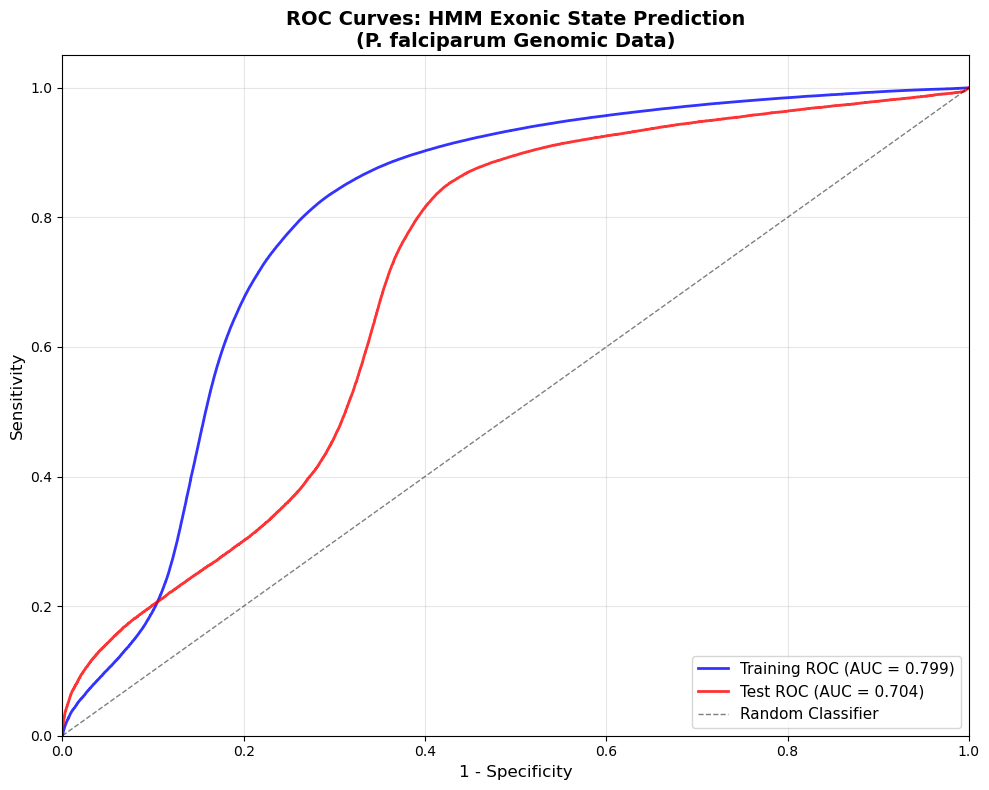

Training AUC: 0.7988
Test AUC:     0.7040


In [61]:
train_auc, test_auc = comprehensive_auc_analysis(hmm, train_seq, train_ann, test_seq, test_ann)